In [195]:
import pandas as pd
import math
import seaborn as sn
from random import seed
from random import randrange
from random import random
%matplotlib inline

class RNA:
    # construtor
    def __init__(self, rate=0.5, epoch=100, error_rate=0.5, output_mode='Logistics'):
        seed(1)
        self.rate = rate
        self.epoch = epoch
        self.inputs = 0
        self.outputs = 0
        self.hiddens = 0
        self.errors = list()
        self.score = 0
        self.network = list()
        self.data = list()
        self.filter = dict()
        self.error_rate = error_rate
        self.mode = output_mode
    
    # exibe os valores
    def show(self):
        out = {
            'rate': self.rate,
            'epoch': self.epoch,
            'inputs': self.inputs,
            'outputs': self.outputs,
            'hiddens': self.hiddens,
            'errors': self.errors,
            'score': self.score,
            'filter': self.filter
        }
        print(out)
    
    # calcula a média geométrica
    def geo_mean(self, inputs, outputs):
        return math.floor(math.sqrt((float(inputs * outputs))))
    
    # carrega o csv, convertendo todo o conteúdo em uma list de lista, converte entrada em float,
    # converte a classe em int e calcula: entradas, saídas e quantidade de neurônios na camada oculta
    def load_data(self, path=''):
        if path != '':
            # carrega o csv
            df = pd.read_csv(path)
            self.data = list()
            # converte em lista de lista
            for i in range(len(df)):
                self.data.append(list(df.loc[i]))
        self.inputs = len(self.data[0]) - 1
        # converte as entradas em float
        for i in range(len(self.data)):
            for j in range(len(self.data[i]) - 1):
                self.data[i][j] = float(self.data[i][j])
        # pega todas as classes no dataset
        last = len(self.data[0]) - 1
        col_class = [row[last] for row in self.data]
        self.outputs = len(set(col_class))
        self.filter = dict()
        # cria um filtro de conversão das classes
        for i, value in enumerate(set(col_class)):
            self.filter[value] = i
        # converte as classes em int
        for row in self.data:
            row[last] = self.filter[row[last]]
        self.hiddens = self.geo_mean(self.inputs, self.outputs)
        self.shuffle()
        self.normalize()
    
    def shuffle(self):
        temp = list(self.data)
        self.data = list()
        while len(temp) > 0:
            index = randrange(len(temp))
            self.data.append(temp.pop(index))
    
    # normaliza os valores de entrada do dataset a fim de deixa-los entre 0 ~ 1
    def normalize(self):
        norm = list()
        state = [[min(col), max(col)] for col in zip(*self.data)]
        for row in self.data:
            for i in range(len(row) - 1):
                row[i] = (row[i] - state[i][0]) / (state[i][1] - state[i][0])
    
    # inicializa a rede neural
    def init_network(self):
        self.network = list()
        # criação dos neurônios da camada oculta
        hidden = [{'W':[random() for _ in range(self.inputs + 1)]} for _ in range(self.hiddens)]
        self.network.append(hidden)
        # criação dos neurônios de saída
        output = [{'W':[random() for _ in range(self.hiddens + 1)]} for _ in range(self.outputs)]
        self.network.append(output)
    
    # ativa os pesos dos neurônios
    def activate(self, weight, inputs):
        act = weight[-1] # bias
        for i in range(len(weight) - 1):
            # sum(weight * input) + bias
            act += weight[i] * inputs[i]
        return act
     
    # executa a função de saída
    def output_function(self, value):
        if self.mode == 'Linear':
            # Linear
            return value / 10.0
        elif self.mode == 'Logistics':
            # Lógica
            return 1.0 / (1.0 + math.exp(-value))
        else:
            # Tangente Hiperbólica
            return math.tanh(value)
    
    def derivative(self, value):
        if self.mode == 'Linear':
            # Linear
            return 1.0 / 10.0
        elif self.mode == 'Logistics':
            # Lógica
            #return value * (1.0 - value)
            x = self.output_function(value)
            return x * (1.0 - x)
        else:
            # Tangente Hiperbólica
            return 1.0 - (self.output_function(value) ** 2)
    
    def forward_propagate(self, row):
        temp_inputs = row
        for layer in self.network:
            news = list()
            for neuron in layer:
                act = self.activate(neuron['W'], temp_inputs)
                neuron['OUTPUT'] = self.output_function(act)
                news.append(neuron['OUTPUT'])
            temp_inputs = news
        return temp_inputs
    
    def backward_propagate_error(self, rec):
        for i in reversed(range(len(self.network))):
            layer = self.network[i]
            errors = list()
            if i != len(self.network)-1:
                for j in range(len(layer)):
                    error = 0.0
                    for neuron in self.network[i + 1]:
                        error += (neuron['W'][j] * neuron['DELTA'])
                    errors.append(error)
            else:
                for j in range(len(layer)):
                    neuron = layer[j]
                    errors.append(rec[j] - neuron['OUTPUT'])
            for j in range(len(layer)):
                neuron = layer[j]
                neuron['DELTA'] = errors[j] * self.derivative(neuron['OUTPUT'])
    
    def update_weights(self, row):
        for i in range(len(self.network)):
            inputs = row[:-1]
            if i != 0:
                inputs = [neuron['OUTPUT'] for neuron in self.network[i - 1]]
            for neuron in self.network[i]:
                for j in range(len(inputs)):
                    neuron['W'][j] += self.rate * neuron['DELTA'] * inputs[j]
                neuron['W'][-1] += self.rate * neuron['DELTA']
    
    def train(self, path='', mode='epoch', data=[]):
        if len(data) == 0:
            self.data = data
        self.load_data(path)
        self.init_network()
        if mode == 'epoch':
            for _ in range(self.epoch):
                error = 0
                for row in self.data:
                    outs = self.forward_propagate(row)
                    rec = [0 for _ in range(self.outputs)]
                    rec[row[-1]] = 1
                    # calcula os resíduos do erro
                    error += sum([abs((rec[i] - outs[i]) * self.derivative(outs[i])) for i in range(len(rec))])
                    # repropaga os erros
                    self.backward_propagate_error(rec)
                    # atualiza os pesos dos neurônios
                    self.update_weights(row)
                self.errors.append(error)
        else:
            error = 100
            while error >= self.error_rate:
                error = 0
                for row in self.data:
                    outs = self.forward_propagate(row)
                    rec = [0 for _ in range(self.outputs)]
                    rec[row[-1]] = 1
                    # calcula os resíduos do erro
                    error += sum([abs((rec[i] - outs[i]) * self.derivative(outs[i])) for i in range(len(rec))])
                    # repropaga os erros
                    self.backward_propagate_error(rec)
                    # atualiza os pesos dos neurônios
                    self.update_weights(row)
                self.errors.append(error)
    
    def predict(self, row):
        outputs = self.forward_propagate(row)
        return outputs.index(max(outputs))
    
    def accuracy(self, facts, predicteds, dist):
        res = 0
        for i in range(len(facts)):
            if facts[i] == predicteds[i]:
                res += 1
        acc = res / float(len(facts)) * 100.0        
        
        matrix = [[0 for _ in range(len(dist))] for _ in range(len(dist))]        
        for i in range(len(facts)):
            matrix[int(facts[i])][int(predicteds[i])] += 1
        df = pd.DataFrame(data=matrix, columns=list(self.filter), index=list(self.filter))
        return (acc, df)
    
    def test(self, path='', data=''):
        dist = list(self.filter)
        if len(data) == 0:
            self.data = data
        self.load_data(path)
        pred = list()
        for row in self.data:
            pred.append(self.predict(row))
        fact = [row[-1] for row in self.data]
        return self.accuracy(fact, pred, dist)
        

100.0


,CA,CE,CD,CB,CC
CA,56,0,0,0,0
CE,0,66,0,0,0
CD,0,0,75,0,0
CB,0,0,0,53,0
CC,0,0,0,0,102


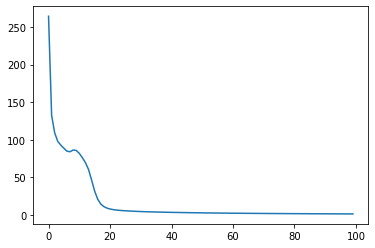

In [200]:
rna = RNA(output_mode='Logistics')
rna.train(path='train.csv')
score, shuf = rna.test(path='test.csv')
print(score)
sn.lineplot(data=rna.errors)
shuf